In [ ]:
import os
import cv2 as cv
import torch
import numpy as np
from transformers import ViTForImageClassification
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO

# Load YOLO models
np_model = YOLO('yolo-best.pt')  # License plate detection model
coco_model = YOLO('yolov8s.pt')  # Vehicle detection model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Vision Transformer (ViT) model for character recognition
characterRecognition = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224', 
    num_labels=36,
    ignore_mismatched_sizes=True
)
checkpoint = torch.load('vit_model.pth')
characterRecognition.load_state_dict(checkpoint)  # Load trained model state
characterRecognition.to(device)
characterRecognition.eval()

# Character mapping dictionary for 36 classes (0-9 and A-Z)
dictionary = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
              10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
              20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
              30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}

# Define preprocessing transform for ViT model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Character recognition function
def VITCharRecognition(img):
    img = Image.fromarray(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = characterRecognition(img).logits
        predicted_idx = torch.argmax(outputs, dim=1).item()
    return dictionary[predicted_idx]

# Adaptive Canny edge detection
def auto_canny(image, sigma=0.33):
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return cv.Canny(image, lower, upper)

# Process detected license plate to recognize characters
def opencvReadPlate(img):
    charList = []
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    thresh_inv = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 39, 1)
    edges = auto_canny(thresh_inv)
    ctrs, _ = cv.findContours(edges.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv.boundingRect(ctr)[0])
    img_area = img.shape[0] * img.shape[1]

    for ctr in sorted_ctrs:
        x, y, w, h = cv.boundingRect(ctr)
        roi_area = w * h
        non_max_sup = roi_area / img_area
        if (non_max_sup >= 0.015) and (non_max_sup < 0.09) and (h > 1.2 * w) and (3 * w >= h):
            char_img = img[y:y + h, x:x + w]
            char = VITCharRecognition(char_img)
            charList.append(char)
            cv.rectangle(img, (x, y), (x + w, y + h), (90, 0, 255), 2)

    return "".join(charList)

# Initialize video capture and get video properties
video_path = 'test.mp4'  # Input video path
video = cv.VideoCapture(video_path)
frame_width = int(video.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv.CAP_PROP_FRAME_HEIGHT))
fps = int(video.get(cv.CAP_PROP_FPS))

# Initialize VideoWriter to save output video
output_video_path = 'output_video1.avi'  # Output video path
fourcc = cv.VideoWriter_fourcc(*'XVID')
out = cv.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

frame_number = 0
vehicles = [2, 3, 5]  # Example class IDs for vehicles (person, car, bus)

while True:
    ret, frame = video.read()
    frame_number += 1

    if not ret:
        break

    # Detect vehicles
    detections = coco_model.track(frame, persist=True)[0]
    for detection in detections.boxes.data.tolist():
        x1, y1, x2, y2, track_id, score, class_id = detection
        if int(class_id) in vehicles and score > 0.5:
            roi = frame[int(y1):int(y2), int(x1):int(x2)]

            # Detect license plates within the ROI
            license_plates = np_model(roi)[0]
            for license_plate in license_plates.boxes.data.tolist():
                plate_x1, plate_y1, plate_x2, plate_y2, plate_score, _ = license_plate
                plate = roi[int(plate_y1):int(plate_y2), int(plate_x1):int(plate_x2)]

                # License plate processing and character recognition
                license_text = opencvReadPlate(plate)
                cv.putText(frame, f'License: {license_text}', (int(x1), int(y1) - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                cv.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

    # Write the processed frame to the output video
    out.write(frame)

# Release video resources
video.release()
out.release()
print("Video processing and saving completed.")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([36]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([36, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



0: 448x640 1 car, 1 bus, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 224x320 1 License_Plate, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)

0: 224x320 1 License_Plate, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)


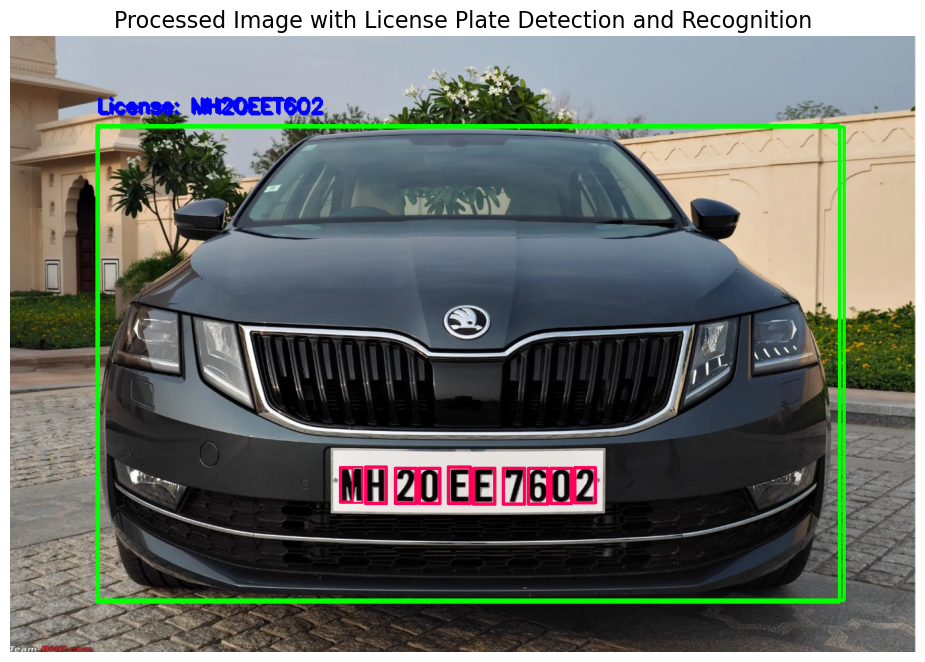

license_text=====================> MH20EET602


In [7]:
import cv2 as cv
import torch
import numpy as np
from transformers import ViTForImageClassification
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLO models
np_model = YOLO('D:/leedcode/License-Plate-Recognition-/trained weight/yolo-best.pt')  # License plate detection model
coco_model = YOLO('yolov8s.pt')  # Vehicle detection model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Vision Transformer (ViT) model for character recognition
characterRecognition = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224', 
    num_labels=36,
    ignore_mismatched_sizes=True
)
checkpoint = torch.load('D:/leedcode/License-Plate-Recognition-/trained weight/vit_model.pth')
characterRecognition.load_state_dict(checkpoint)  # Load trained model state
characterRecognition.to(device)
characterRecognition.eval()

# Character mapping dictionary for 36 classes (0-9 and A-Z)
dictionary = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
              10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
              20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
              30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}

# Define preprocessing transform for ViT model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Character recognition function
def VITCharRecognition(img):
    img = Image.fromarray(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = characterRecognition(img).logits
        predicted_idx = torch.argmax(outputs, dim=1).item()
    return dictionary[predicted_idx]

# Adaptive Canny edge detection
def auto_canny(image, sigma=0.33):
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return cv.Canny(image, lower, upper)

# Process detected license plate to recognize characters
def opencvReadPlate(img):
    charList = []
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    thresh_inv = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 39, 1)
    edges = auto_canny(thresh_inv)
    ctrs, _ = cv.findContours(edges.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv.boundingRect(ctr)[0])
    img_area = img.shape[0] * img.shape[1]

    for ctr in sorted_ctrs:
        x, y, w, h = cv.boundingRect(ctr)
        roi_area = w * h
        non_max_sup = roi_area / img_area
        if (non_max_sup >= 0.015) and (non_max_sup < 0.09) and (h > 1.2 * w) and (3 * w >= h):
            char_img = img[y:y + h, x:x + w]
            char = VITCharRecognition(char_img)
            charList.append(char)
            cv.rectangle(img, (x, y), (x + w, y + h), (90, 0, 255), 2)

    return "".join(charList)

# Load a test image
image_path = 'D:/leedcode/License-Plate-Recognition-/test_data/car_license_plate.PNG'  # Path to the input image
image = cv.imread(image_path)
vehicles = [2, 3, 5]  # Example class IDs for vehicles

# Detect vehicles
detections = coco_model.track(image, persist=True)[0]
processed_vehicle_ids = set()  # Track processed vehicle IDs
for detection in detections.boxes.data.tolist():
    x1, y1, x2, y2, track_id, score, class_id = detection
    if int(class_id) in vehicles and score > 0.5 and track_id not in processed_vehicle_ids:
        processed_vehicle_ids.add(track_id)  # Ensure only one bounding box per vehicle
        roi = image[int(y1):int(y2), int(x1):int(x2)]

        # Detect license plates within the ROI
        license_plates = np_model(roi)[0]
        for license_plate in license_plates.boxes.data.tolist():
            plate_x1, plate_y1, plate_x2, plate_y2, plate_score, _ = license_plate
            plate = roi[int(plate_y1):int(plate_y2), int(plate_x1):int(plate_x2)]

            # License plate processing and character recognition
            license_text = opencvReadPlate(plate)
            cv.putText(image, f'License: {license_text}', (int(x1), int(y1) - 20), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
            cv.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 3)

# Display the processed image using Matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.title("Processed Image with License Plate Detection and Recognition", fontsize=16)
plt.axis('off')
plt.show()
print("license_text=====================>",license_text)